In [2]:
%pip install .

Processing /Users/leonard/dev/projects/university/orbitronics_research_project
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for realspace_tb: filename=realspace_tb-0.1-py3-none-any.whl size=40049 sha256=3e186ea2c4641ea56e4dd50922843bfc2448769fe253ba081eae29cc835da080
  Stored in directory: /private/var/folders/2f/qsk40ts91rs8dfrbwykc6d080000gn/T/pip-ephem-wheel-cache-8yz9bflz/wheels/9f/58/e4/ee6166b96636b31fb047f8712656325a05a996aba04989ca17
Successfully built realspace_tb

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import realspace_tb as tb
import numpy as np

In [15]:
# Hamiltonian with homogeneous AC field via onsite potentials
H = tb.LinearFieldHamiltonian(
    tb.HoneycombLatticeGeometry(Lx=11, Ly=20),  # Graphene-like system
    tb.RampedACFieldAmplitude(
        E0=1e-3, omega=1.0, T_ramp=2 * np.pi, direction=np.array([0, 1])
    ),  # Ramp up to field amplitude E0=1e-3 in y-direction
)

In [16]:
# Initial state
rho = H.ground_state_density_matrix(fermi_level=0.0)

Calculating eigenvalues at t=0...


In [ ]:
# Evolve rho in time with RK4 solver and observe orbital polarization
orb_pol = tb.OrbitalPolarizationHoneycomb(H.geometry, measurement_start_time=5 * np.pi)

tb.RK4NeumannSolver().evolve(
    rho, H, dt=0.1, total_time=10 * np.pi, tau=10.0, observables=[orb_pol]
)

100%|██████████| 314/314 [00:01<00:00, 280.94it/s]


Text(0, 0.5, '$P_\\mathrm{orb}^{x}$')

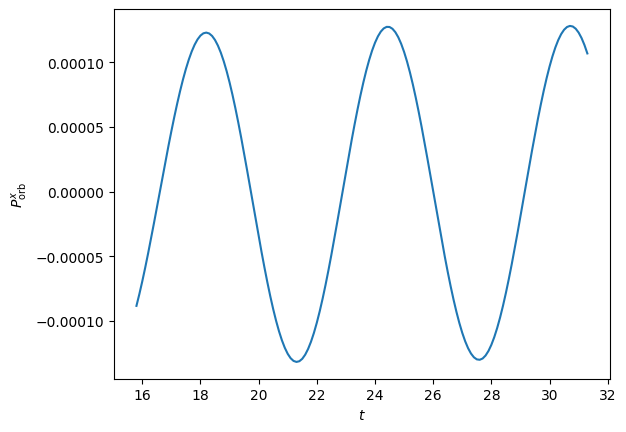

In [ ]:
# Plot orbital polarization (x-comp.) over time
import matplotlib.pyplot as plt

plt.plot(orb_pol.measurement_times, orb_pol.values[:, 0])
plt.xlabel("$t$")
plt.ylabel(r"$P_\mathrm{orb}^{x}$")

In [21]:
# Calculate orbital hall conductivity from polarisation current
P_x = orb_pol.values[:, 0]
t = orb_pol.measurement_times
orb_current = (np.diff(P_x) / np.diff(t))[1:]
E = H.field.amplitude_at_time(t[:-1])
dt = t[1] - t[0]

sigma_orb_xy = tb.ohc(orb_current, E, dt, H.field.omega)

print(f"Absolute OHC {abs(sigma_orb_xy):.2f} e/2pi, phase {np.angle(sigma_orb_xy):.2f} rad")

Absolute OHC 0.79 e/2pi, phase -2.33 rad
